In [1]:
!pip install -U transformers datasets scikit-learn huggingface_hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" 

In [2]:
from datasets import load_dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
    AutoModelForSequenceClassification,
    AutoTokenizer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from huggingface_hub import notebook_login
import numpy as np
import torch
import matplotlib.pyplot as plt
import os


In [3]:
os.environ["WANDB_DISABLED"] = "true"


In [4]:
dataset = load_dataset("ag_news")

print(dataset)
print(dataset["train"][0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


In [5]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [6]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [7]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(2000))
test_dataset = tokenized_datasets["test"].select(range(500))


In [8]:
training_args = TrainingArguments(
    output_dir="./results_agnews",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    logging_dir="./logs_agnews",
    logging_steps=20,
    report_to="none",
    fp16=True
)


In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [10]:
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=4
)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-11-2147312783.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [12]:
trainer.train()


Step,Training Loss
20,1.260500
40,0.539900
60,0.377600
80,0.386300
100,0.433100
120,0.348900
140,0.304100
160,0.190800
180,0.282400
200,0.307400


TrainOutput(global_step=250, training_loss=0.40970466899871827, metrics={'train_runtime': 4764.5788, 'train_samples_per_second': 0.84, 'train_steps_per_second': 0.052, 'total_flos': 263115780096000.0, 'train_loss': 0.40970466899871827, 'epoch': 2.0})

In [13]:
model.save_pretrained("./roberta-agnews")
tokenizer.save_pretrained("./roberta-agnews")


('./roberta-agnews/tokenizer_config.json',
 './roberta-agnews/special_tokens_map.json',
 './roberta-agnews/vocab.json',
 './roberta-agnews/merges.txt',
 './roberta-agnews/added_tokens.json',
 './roberta-agnews/tokenizer.json')

In [14]:
results = trainer.evaluate()
print(results)


{'eval_loss': 0.42065879702568054, 'eval_accuracy': 0.886, 'eval_f1': 0.8811374345351775, 'eval_precision': 0.8818388567983919, 'eval_recall': 0.8818115396989991, 'eval_runtime': 171.3897, 'eval_samples_per_second': 2.917, 'eval_steps_per_second': 0.093, 'epoch': 2.0}


In [15]:
label_map = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

sentiment_pipe = pipeline(
    "text-classification",
    model="./roberta-agnews",
    tokenizer="./roberta-agnews"
)

texts = [
    "The stock market saw significant gains today, led by tech stocks.",
    "The football team won their final match of the season.",
    "NASA announced a new space mission to Mars.",
    "The president held a press conference to discuss foreign policy."
]

for text in texts:
    result = sentiment_pipe(text)[0]
    category = label_map[int(result["label"].split("_")[-1])]
    score = result["score"]
    print(f"Text: {text}")
    print(f"Predicted category: {category} (confidence: {score:.2f})\n")


Device set to use cpu


Text: The stock market saw significant gains today, led by tech stocks.
Predicted category: Business (confidence: 0.98)

Text: The football team won their final match of the season.
Predicted category: Sports (confidence: 0.98)

Text: NASA announced a new space mission to Mars.
Predicted category: Sci/Tech (confidence: 0.98)

Text: The president held a press conference to discuss foreign policy.
Predicted category: World (confidence: 0.98)



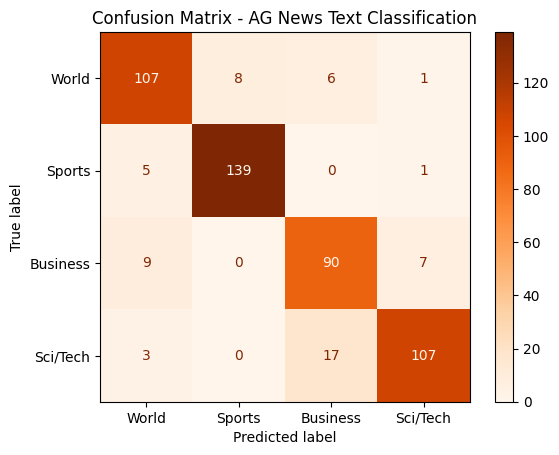

In [16]:
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in torch.utils.data.DataLoader(test_dataset, batch_size=32):
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["World", "Sports", "Business", "Sci/Tech"]
)
disp.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix - AG News Text Classification")
plt.show()


In [17]:
from huggingface_hub import notebook_login

notebook_login()


In [18]:
model_id = "Anirudhchevva/agnews-text-classification-roberta"


In [19]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Path where your model was saved locally
model_path = "./roberta-agnews"

# Load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Upload to Hugging Face Hub
model.push_to_hub(model_id)
tokenizer.push_to_hub(model_id)


Uploading...:   0%|          | 0.00/499M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Anirudhchevva/agnews-text-classification-roberta/commit/69aa1ed02ba2eb3e4ebb6ca3317ae8698cf4e5c8', commit_message='Upload tokenizer', commit_description='', oid='69aa1ed02ba2eb3e4ebb6ca3317ae8698cf4e5c8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Anirudhchevva/agnews-text-classification-roberta', endpoint='https://huggingface.co', repo_type='model', repo_id='Anirudhchevva/agnews-text-classification-roberta'), pr_revision=None, pr_num=None)

In [20]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model="Anirudhchevva/agnews-text-classification-roberta"
)

print(classifier("NASA is launching a new mission to study Mars."))


config.json:   0%|          | 0.00/892 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'LABEL_3', 'score': 0.9799321293830872}]
